In [10]:
import os
import sys
import re
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import copy
import pickle
import multiprocessing as mp

In [11]:
sys.getdefaultencoding()

'utf-8'

In [12]:
# jupyter notebook settings for debugging
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
# statmech library setup
sys.path.append('../../statmechlib')
from statmechlib.read_write import read_vasp
from statmechlib.preprocessing import Trajectory, select_nodes, scale_configuration, pair_dist
from statmechlib.preprocessing import pair_dist, force_targ, get_stats_EAM_per_atom, get_stats_EAM_per_box

In [17]:
# Define locations of relevant datasets

target_raw = '../data/target_raw'
target_proc = '../data/target_processed'
working = '../data/working'

# MD trajectories
datasets_MD = ['bcc_npt_langevin_300K',
            'fcc_npt_langevin_300K',
            'vac_npt_langevin_2000K',
            'i110_npt_langevin_2000K',
            'i111_npt_langevin_2000K',
            'screw_111_npt_langevin_2000K',
            'bcc_npt_langevin_3700K',
            'liq_3700K',
            'liq_5000K']

# 0K relaxed structures
datasets_0k = ['bcc_0k',
               'fcc_0k',
               'vac_0k',
               'i110_0k',
               'i111_0k',
               'screw_111_0k']

# equations of state for BCC and FCC lattices
configs = ['v0','v0.8','v0.9','v1.1','v1.2','v1.3','v1.4','v1.5']

datasets_eos_bcc = ['eq_st_bcc/' + s for s in configs]
datasets_eos_fcc = ['eq_st_fcc/' + s for s in configs]

# bain path
configs = ['1.00', '1.05', '1.10', '1.15', '1.20', '1.25', '1.30', '1.35', '1.40', '1.45', '1.50', '1.55']

datasets_bain = ['bain_path/' + s for s in configs]

# vacancy interactions

configs = ['v2_r1', 'v2_r2', 'v2_r3', 'v3_1_555', 'v3_3_555', 'v4_2_555', 'v4_5_555', 'v5_555', 'v6_555', 'v6_6x6x6_360']#, 'prf_360']

datasets_vacint = ['vacint/' + s for s in configs]

# defined dataset directories relative to the current directory (/notebooks)
trajdirs_MD = [target_raw + '/' + dataset for dataset in datasets_MD]
trajdirs_0k = [target_raw + '/' + dataset for dataset in datasets_0k]
trajdirs_eos_bcc = [target_raw + '/' + dataset for dataset in datasets_eos_bcc]
trajdirs_eos_fcc = [target_raw + '/' + dataset for dataset in datasets_eos_fcc]
trajdirs_bain = [target_raw + '/' + dataset for dataset in datasets_bain]
trajdirs_vacint = [target_raw + '/' + dataset for dataset in datasets_vacint]

In [18]:
%%time

# set up a multiprocessing pool
pool = mp.Pool()

# read vacancy interactins in parallel
output_data = pool.map(read_vasp, trajdirs_vacint)
trajectories_vacint = dict(zip(datasets_vacint, output_data))
print('Done with vacint')

# read MD trajectories in parallel
output_data = pool.map(read_vasp, trajdirs_MD)
trajectories_MD = dict(zip(datasets_MD, output_data))
print('Done with MD')

# read 0K configurations in parallel
output_data = pool.map(read_vasp, trajdirs_0k)
trajectories_0k = dict(zip(datasets_0k, output_data))
print('Done with 0k')

# read BCC EOS in parallel
output_data = pool.map(read_vasp, trajdirs_eos_bcc)
trajectories_eos_bcc = dict(zip(datasets_eos_bcc, output_data))
print('Done with BCC EOS')

# read BCC EOS in parallel
output_data = pool.map(read_vasp, trajdirs_eos_fcc)
trajectories_eos_fcc = dict(zip(datasets_eos_fcc, output_data))
print('Done with FCC EOS')

# read bain path in parallel
output_data = pool.map(read_vasp, trajdirs_bain)
trajectories_bain = dict(zip(datasets_bain, output_data))
print('Done with bain path')

pool.close()
pool.join()

Done with vacint
Done with MD
Done with 0k
Done with BCC EOS
Done with FCC EOS
Done with bain path
CPU times: user 716 ms, sys: 427 ms, total: 1.14 s
Wall time: 5min


In [19]:
for k, trj in trajectories_vacint.items():
    print(k, len(trj['xyz']))

vacint/v2_r1 6
vacint/v2_r2 9
vacint/v2_r3 3
vacint/v3_1_555 3
vacint/v3_3_555 3
vacint/v4_2_555 1
vacint/v4_5_555 3
vacint/v5_555 3
vacint/v6_555 3
vacint/v6_6x6x6_360 3


In [20]:
# Convert MD trajectory dicts to objects
trjs_MD = {}
for k, trj in trajectories_MD.items():
    trjs_MD[k] = Trajectory(trj, inplace=False)
    
# Convert 0K configs to objects
trjs_0k = {}
for k, trj in trajectories_0k.items():
    trjs_0k[k] = Trajectory(trj, inplace=False)[-1]

# Convert bcc eos configs to objects
trjs_eos_bcc = {}
for k, trj in trajectories_eos_bcc.items():
    trjs_eos_bcc[k] = Trajectory(trj, inplace=False)[-1]
    
# Convert fcc eos configs to objects
trjs_eos_fcc = {}
for k, trj in trajectories_eos_fcc.items():
    trjs_eos_fcc[k] = Trajectory(trj, inplace=False)[-1]
    
# Convert bain path configs to objects
trjs_bain = {}
for k, trj in trajectories_bain.items():
    trjs_bain[k] = Trajectory(trj, inplace=False)[-1]
    
# Convert vacint configs to objects
trjs_vacint = {}
for k, trj in trajectories_vacint.items():
    trjs_vacint[k] = Trajectory(trj, inplace=False)[-1]

In [21]:
print(trjs_0k['bcc_0k']['energy'])
trjs_0k['bcc_0k']['energy'] = [-1656.28114021]

[-1656.3257]


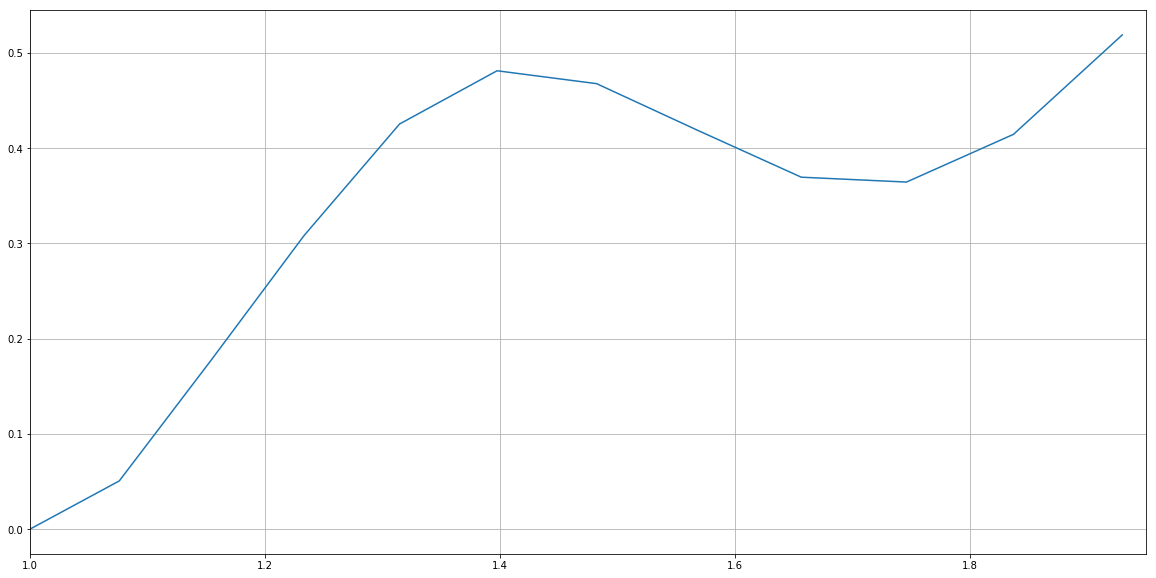

In [22]:
plt.figure(figsize=(20,10))
ratio = [trjs_bain[key]['box'][0][2,2]/trjs_bain[key]['box'][0][0,0] for key in datasets_bain]
plt.plot(ratio, np.array([trjs_bain[key]['energy'] for key in datasets_bain])/128.- trjs_bain['bain_path/1.00']['energy'][-1]/128.)
plt.xlim(1.0, 1.95)
plt.grid(True)

[6.430017071480506, 6.784700231481111, 6.276900231480795, 9.969466412036581, 9.75526641203669, 13.85798152777761, 12.321581527777653, 15.91409664351795, 17.0665117592589, 16.9537606944441]
[6.192567520000011, 6.547250680000616, 6.0394506800003, 9.833070972000314, 9.618870972000423, 13.72213829600014, 12.185738296000181, 15.778805620000185, 16.93177294399993, 16.718519976000607]
[430 430 430 247 247 246 246 245 244 426]


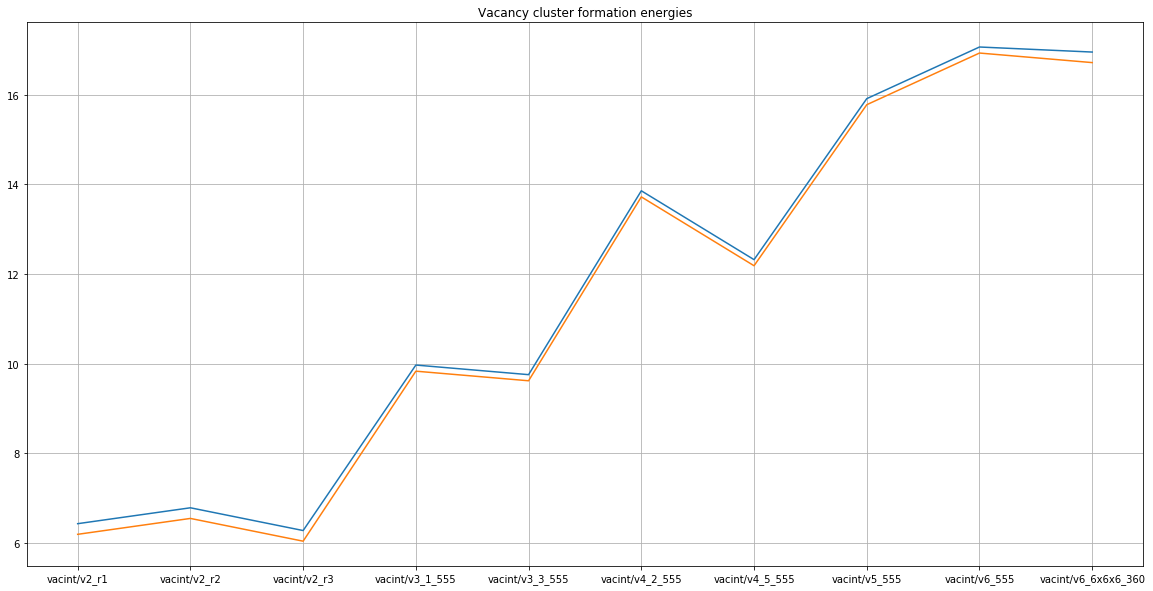

In [23]:
plt.figure(figsize=(20,10))
#ratio = [trjs_vacint[key]['box'][0][2,2]/trjs_bain[key]['box'][0][0,0] for key in datasets_bain]
plt.title('Vacancy cluster formation energies')
nat = np.array([len(trjs_vacint[key]['xyz'][-1]) for key in sorted(datasets_vacint)])
enes_big =   [trjs_vacint[key]['energy'][-1] + 5598.713470/432*nat[i] for i, key in enumerate(sorted(datasets_vacint))]
enes_small = [trjs_vacint[key]['energy'][-1] + 3239.858169/250*nat[i] for i, key in enumerate(sorted(datasets_vacint))]

#plt.plot(np.array([trjs_vacint[key]['energy'][-1] for key in datasets_vacint])/nat - 8.9)
#plt.xlim(1.0, 1.95)
plt.grid(True)
plt.plot(enes_big)
plt.plot(enes_small)
#plt.plot(np.array([trjs_vacint[key]['energy'][-1] for key in sorted(datasets_vacint)]) - trjs_0k['bcc_0k']['energy'][-1]/128.*nat)
x_ticks = (list(range(len(trjs_vacint.keys()))), sorted(list(trjs_vacint.keys())))
plt.xticks(*x_ticks)


print([trjs_vacint[key]['energy'][-1] + 5598.713470/432*nat[i] for i, key in enumerate(sorted(datasets_vacint))])
print([trjs_vacint[key]['energy'][-1] + 3239.858169/250*nat[i] for i, key in enumerate(sorted(datasets_vacint))])
print(nat)

In [24]:
# Join relaxed configurations into pseudo-trajectories

# join 0 K configurations into a pseudo-trajectory
traj_0k = copy.deepcopy(trjs_0k['bcc_0k'])
for k, trj in sorted(trjs_0k.items()):
    if 'bcc_0k' not in k:
        traj_0k.append(trj)

# join eos bcc configurations into a pseudo-trajectory
traj_eos_bcc = copy.deepcopy(trjs_eos_bcc['eq_st_bcc/v0'])
for k, trj in sorted(trjs_eos_bcc.items()):
    if k != 'eq_st_bcc/v0':
        traj_eos_bcc.append(trj)

# join eos fcc configurations into a pseudo-trajectory
traj_eos_fcc = copy.deepcopy(trjs_eos_fcc['eq_st_fcc/v0'])
for k, trj in sorted(trjs_eos_fcc.items()):
    #if k != 'eq_st_fcc/v0':
    if ('v0.8' in k) or ('v0.9' in k) or ('v1.1' in k) or ('v1.2' in k):
        traj_eos_fcc.append(trj)
        
# join bain path configurations into a pseudo-trajectory
traj_bain = copy.deepcopy(trjs_bain['bain_path/1.00'])
for k, trj in sorted(trjs_bain.items()):
    if k != 'bain_path/1.00':
        traj_bain.append(trj)
        
# join vacint configurations into a pseudo-trajectory
traj_vacint = copy.deepcopy(trjs_vacint['vacint/v2_r1'])
for k, trj in sorted(trjs_vacint.items()):
    if k != 'vacint/v2_r1':
        traj_vacint.append(trj)

In [25]:
# Create a dictionary of trajectories
trjs = {}
trjs.update(trjs_MD)
trjs['relax'] = traj_0k
trjs['eos_bcc'] = traj_eos_bcc
trjs['eos_fcc'] = traj_eos_fcc
trjs['bain'] = traj_bain
trjs['vacint'] = traj_vacint

In [26]:
trjs['relax']['box'], trjs['bain']['box']

([array([[12.744894,  0.      ,  0.      ],
         [ 0.      , 12.744894,  0.      ],
         [ 0.      ,  0.      , 12.744894]]),
  array([[12.10561061,  0.        ,  0.        ],
         [ 0.        , 12.10561061,  0.        ],
         [ 0.        ,  0.        , 12.10561061]]),
  array([[12.6836,  0.    ,  0.    ],
         [ 0.    , 12.6836,  0.    ],
         [ 0.    ,  0.    , 12.6836]]),
  array([[12.6836,  0.    ,  0.    ],
         [ 0.    , 12.6836,  0.    ],
         [ 0.    ,  0.    , 12.6836]]),
  array([[39.073002,  0.      ,  0.      ],
         [ 0.      ,  2.762878,  0.      ],
         [19.536501,  1.381439, 20.302927]]),
  array([[12.729505,  0.      ,  0.      ],
         [ 0.      , 12.729505,  0.      ],
         [ 0.      ,  0.      , 12.729505]])],
 [array([[12.744894,  0.      ,  0.      ],
         [ 0.      , 12.744894,  0.      ],
         [ 0.      ,  0.      , 12.744894]]),
  array([[12.437743,  0.      ,  0.      ],
         [ 0.      , 12.437743,  0.

In [27]:
# shift zero of energy to by subtracting intra-atomic contributions (energy of an isolated atom)

u_total = traj_0k['energy'][0]/len(traj_0k['xyz'][0]) # total energy of a BCC lattice from DFT
u_lattice = -8.9 # experimental lattice energy of a BCC lattice
#u_lattice = -8.89965188
u_intra = u_total - u_lattice # internal energy per atom (to be subtracted from all atoms)

for key, trj_i in trjs.items():
    print(key, type(trj_i))
    trj_i.set_zero_energy(u_intra, inplace=True)

bcc_npt_langevin_300K <class 'statmechlib.preprocessing.trajectory.Trajectory'>
fcc_npt_langevin_300K <class 'statmechlib.preprocessing.trajectory.Trajectory'>
vac_npt_langevin_2000K <class 'statmechlib.preprocessing.trajectory.Trajectory'>
i110_npt_langevin_2000K <class 'statmechlib.preprocessing.trajectory.Trajectory'>
i111_npt_langevin_2000K <class 'statmechlib.preprocessing.trajectory.Trajectory'>
screw_111_npt_langevin_2000K <class 'statmechlib.preprocessing.trajectory.Trajectory'>
bcc_npt_langevin_3700K <class 'statmechlib.preprocessing.trajectory.Trajectory'>
liq_3700K <class 'statmechlib.preprocessing.trajectory.Trajectory'>
liq_5000K <class 'statmechlib.preprocessing.trajectory.Trajectory'>
relax <class 'statmechlib.preprocessing.trajectory.Trajectory'>
eos_bcc <class 'statmechlib.preprocessing.trajectory.Trajectory'>
eos_fcc <class 'statmechlib.preprocessing.trajectory.Trajectory'>
bain <class 'statmechlib.preprocessing.trajectory.Trajectory'>
vacint <class 'statmechlib.prepr

In [28]:
u_total, u_lattice, u_intra, trjs['relax']['energy'], trjs['vacint']['energy']

(-12.939696407890626,
 -8.9,
 -4.0396964078906255,
 [-1139.2,
  -907.0154879478124,
  -1136.4010633821094,
  -1136.7508633821094,
  -1190.2611849347657,
  -1127.1746561978907],
 [-3829.2940277670314,
  -3828.9393446070308,
  -3829.447144607031,
  -2193.3417872510154,
  -2193.5559872510153,
  -2180.5329836589062,
  -2182.069383658906,
  -2169.556580066797,
  -2159.4838764746873,
  -3783.089130238593])

In [29]:
np.array(trjs['relax']['energy'])/np.array([len(x) for x in trjs['relax']['xyz']])

array([-8.9       , -8.39829156, -8.80931057, -8.8120222 , -8.81674952,
       -8.87539099])

In [30]:
#%%writefile -a ../../statmechlib/statmechlib/preprocessing/stats.py

# W parameters
l = 0.274
r_wse = 3.168
r_wse = 1.584
eta = 5.69
dE = 8.9#8.89965188

# equation of state. x is lattice expansion/compression parameter
def eos(x):
    a = (x - 1.0)*r_wse/l
    ene = np.exp(-a)
    ene *= -1.0 - a - 0.05*a**3
    return dE*ene


def scale_configuration(trj, scale):
    """
    Scales box size by 10 to separate all atoms beyond cutoff, and sets energies and forces to 0.
    
    Parameters
    ----------
    trj: Trajectory object (or dict)
         Trajectory to be rescaled
    
    Returns
    -------
    trj: Trajectory object (or dict)
         Rescaled trajectory
    """
    edif = 0.0#-1656.3257 + 1139.2
    trj['box'][0] = trj['box'][0]*scale
    trj['box0'] = trj['box0']*scale
    trj['energy'][0] = eos(scale)*len(trj['xyz'][0]) + edif
    trj['free_energy'][0] = eos(scale)*len(trj['xyz'][0]) + edif
    trj['total_energy'][0] = eos(scale)*len(trj['xyz'][0]) + edif
    trj['forces'][0] = np.zeros_like(trj['forces'][0])
    return trj

In [31]:
trjs_0k['bcc_0k']['total_energy'], trjs['relax'][0]['energy']

([-1656.3257], [-1139.2])

In [32]:
# Create configurations and energies based on universal equation of state for BCC tungsten
#traj_eos = scale_configuration(copy.deepcopy(trjs['relax'][0]['bcc_0k']), 1.0)
traj_eos = scale_configuration(copy.deepcopy(trjs['relax'][0]), 1.0)

# select configurations outside the range of direct DFT EOS calculations
scale_eos = [0.85, 0.9, 1.2, 1.25, 1.3, 1.35, 1.4, 1.45]

for scale in scale_eos:
    #traj_scale = copy.deepcopy(trjs_0k['bcc_0k'])
    traj_scale = copy.deepcopy(trjs['relax'][0])
    traj_eos.append(scale_configuration(traj_scale, scale))

In [33]:
trjs['eos'] = traj_eos

In [34]:
# Create an artificial 'infinite' configuration with large box and 0 energy
#traj_inf = copy.deepcopy(trjs_0k['bcc_0k'])
traj_inf = copy.deepcopy(trjs['relax'][0])
traj_inf = scale_configuration(traj_inf, 100.0)
traj_inf['temp'] = [100.0]

In [35]:
# Add inf configuration to static pseudo-trajectory and set temperature to 100 K (for convenience)
for key in ['relax','eos','eos_bcc','eos_fcc']:
    #trjs[key].append(traj_inf)
    trjs[key]['temp'] = [100.0 for _ in range(len(trjs[key]['energy']))]

[-1139.1999597899999, -1022.8512597899999, -1114.8629597899999, -1123.98065979, -1084.68265979, -1031.68535979, -971.3638597899999, -907.73125979]
[-910.3360879478124, -816.7254879478124, -890.3913879478124, -897.9182879478125, -865.9315879478125]
[-1139.2, -271.8047221070888, -837.1711089986524, -800.6633444635341, -697.0611202328876, -602.3043063713139, -517.742999456512, -443.4032853774631, -378.657941519064]


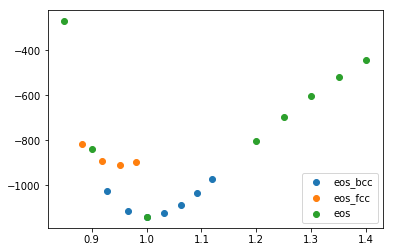

In [36]:
for key, trj in trjs.items():
    #print(i, list(zip(trj['atom_name'], trj['atom_num'])), len(trj['temp']))
    if 'eos' in key:
        plt.scatter([np.linalg.det(b)**(1./3.)/12.744894 for b in trj['box']][:-1], trj['energy'][:-1], label=key)
        print(trj['energy'][:])
plt.legend()
#plt.xlim(-1780,-1100)
plt.show()

In [37]:
def get_msd(xyzs):
    """Return mean squared displacement (msd) for a given trajectory (traj)."""
    msd = []
    for rs in xyzs:
        msd.append(np.mean((rs - xyzs[0])**2))
    #msd = [0.0 for _ in range(len(xyzs))]
    return np.array(msd)

No handles with labels found to put in legend.


[7.91427717257581, 9.235487802783931, 8.029570717424228, 8.029570717424228, 7.475199683027163, 7.943015157820841]


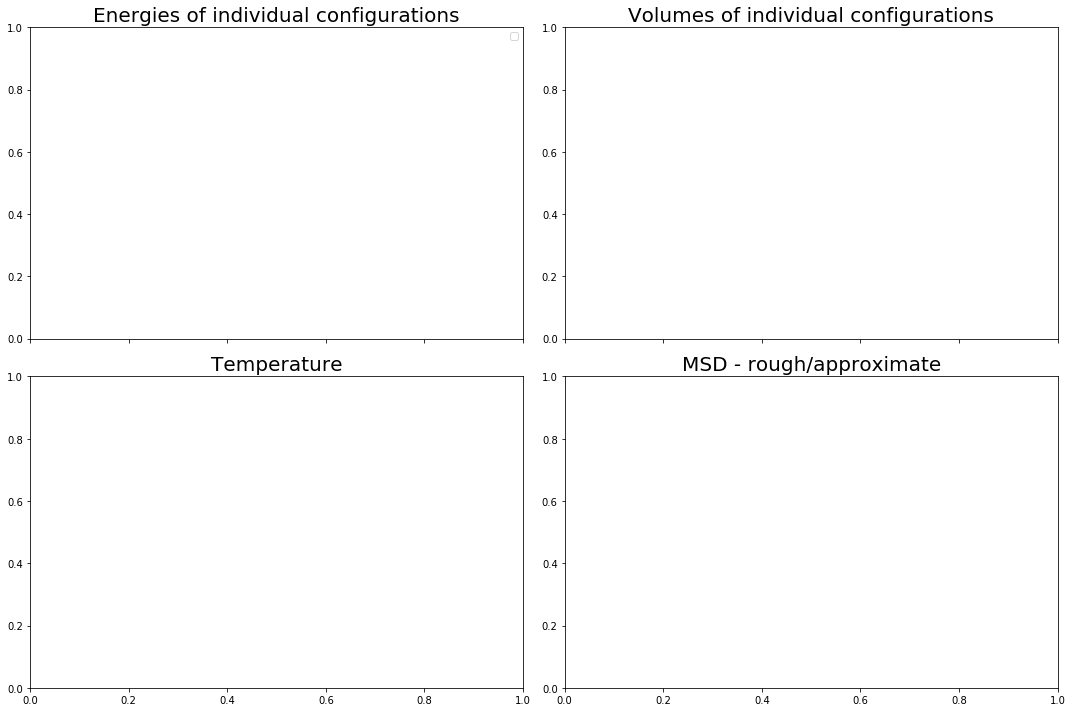

In [82]:
fig, axes = plt.subplots(2, 2, sharex='col', figsize=(15,10))

for key, traj in trjs.items():
    if 'relax' in key or 'eos' in key or 'vacint':
        continue

        
    #axes[0,0].plot([e/x.shape[0] for e, x in zip(traj['energy'], traj['xyz'])], label=dset)
    if 'screw' in key:
        axes[0,0].plot([e for e, x in zip(traj['energy'], traj['xyz'])], label=key)
        axes[0,1].plot([np.linalg.det(b) for b in traj['box']], label=key)
    else:
        axes[0,0].plot([e for e, x in zip(traj['energy'], traj['xyz'])], label=key)
        axes[0,1].plot([np.linalg.det(b) for b in traj['box']], label=key)


    axes[1,0].plot([t for t in traj['temp']], label=key)

    msd = get_msd(traj['xyz'])
    axes[1,1].plot(msd, label=key)

axes[0,0].legend()
axes[0,0].set_title('Energies of individual configurations', fontsize=20)
axes[0,1].set_title('Volumes of individual configurations', fontsize=20)       
axes[1,0].set_title('Temperature', fontsize=20)
axes[1,1].set_title('MSD - rough/approximate', fontsize=20)
fig.tight_layout()

print([128*128/np.linalg.det(b) for b in trjs['relax']['box']])

In [39]:
[(k, len(v['energy'])) for k, v in trjs.items()]

[('bcc_npt_langevin_300K', 1496),
 ('fcc_npt_langevin_300K', 552),
 ('vac_npt_langevin_2000K', 1480),
 ('i110_npt_langevin_2000K', 1461),
 ('i111_npt_langevin_2000K', 1477),
 ('screw_111_npt_langevin_2000K', 1992),
 ('bcc_npt_langevin_3700K', 1329),
 ('liq_3700K', 1153),
 ('liq_5000K', 1406),
 ('relax', 6),
 ('eos_bcc', 8),
 ('eos_fcc', 5),
 ('bain', 12),
 ('vacint', 10),
 ('eos', 9)]

In [40]:
slices = {'bcc_npt_langevin_300K':slice(500, None,5),
        'fcc_npt_langevin_300K':slice(50, None, 5),
        'vac_npt_langevin_2000K':slice(300, None, 5),
        'i110_npt_langevin_2000K':slice(1000, None, 5),
        'i111_npt_langevin_2000K':slice(1000, None, 5),
        'screw_111_npt_langevin_2000K':slice(1400, None, 5),
        'bcc_npt_langevin_3700K':slice(600, None, 5),
        'liq_3700K':slice(800, None, 5),
        'liq_5000K':slice(800, None, 5),
        'relax':slice(0, None, None),
        'eos_bcc':slice(0, None, None),
        'eos_fcc':slice(0, None, None),
        'eos':slice(0, None, None),
        'bain':slice(0, None, None),
        'vacint':slice(0, None, None)
       }

In [41]:
trj_samples = {}
for key, traj in trjs.items():
    trj_samples[key] = traj[slices[key]]

In [42]:
[(k, len(v['energy'])) for k, v in trj_samples.items()]

[('bcc_npt_langevin_300K', 200),
 ('fcc_npt_langevin_300K', 101),
 ('vac_npt_langevin_2000K', 236),
 ('i110_npt_langevin_2000K', 93),
 ('i111_npt_langevin_2000K', 96),
 ('screw_111_npt_langevin_2000K', 119),
 ('bcc_npt_langevin_3700K', 146),
 ('liq_3700K', 71),
 ('liq_5000K', 122),
 ('relax', 6),
 ('eos_bcc', 8),
 ('eos_fcc', 5),
 ('bain', 12),
 ('vacint', 10),
 ('eos', 9)]

In [43]:
#traj_inf['ensemble'], traj_md['ensemble'], trj_samples['bcc_npt_langevin_300K']['ensemble']

In [44]:
# join all MD configurations into a pseudo-trajectory (to properly weigh phase stability)
traj_md = copy.deepcopy(trj_samples['bcc_npt_langevin_300K'])

for k, trj in trj_samples.items():
    print(k)
    if 'vacint' in k or 'bain' in k or 'eos' in k or 'relax' in k or 'bcc_npt_langevin_300K' in k: 
        continue
        
    traj_md.append(trj)

    print(len(traj_md['box']))

# add inf configurations at the end to define zero of potential energy
traj_inf_md = copy.deepcopy(traj_inf)
traj_inf_md['ensemble'] = 'md'
for i in range(0):#range(200):
    traj_md.append(traj_inf_md)

bcc_npt_langevin_300K
fcc_npt_langevin_300K
301
vac_npt_langevin_2000K
537
i110_npt_langevin_2000K
630
i111_npt_langevin_2000K
726
screw_111_npt_langevin_2000K
845
bcc_npt_langevin_3700K
991
liq_3700K
1062
liq_5000K
1184
relax
eos_bcc
eos_fcc
bain
vacint
eos


In [45]:
#trj_samples['eos_bcc'].append(trj_samples['eos'])

In [46]:
trj_samples['eos_bcc']['energy']

[-1139.1999597899999,
 -1022.8512597899999,
 -1114.8629597899999,
 -1123.98065979,
 -1084.68265979,
 -1031.68535979,
 -971.3638597899999,
 -907.73125979]

In [47]:
trj_fit = {}
trj_fit.update(trj_samples)
#trj_fit.update({'md':traj_md}),

In [48]:
#trj_fit = {'md':traj_md,
#           'relax':trj_samples['relax'],
#           'eos_bcc':trj_samples['eos_bcc'],
#           'eos_fcc':trj_samples['eos_fcc'],
#           'bain':trj_samples['bain']}

In [49]:
trj_fit.keys(), type(trj_fit)

(dict_keys(['bcc_npt_langevin_300K', 'fcc_npt_langevin_300K', 'vac_npt_langevin_2000K', 'i110_npt_langevin_2000K', 'i111_npt_langevin_2000K', 'screw_111_npt_langevin_2000K', 'bcc_npt_langevin_3700K', 'liq_3700K', 'liq_5000K', 'relax', 'eos_bcc', 'eos_fcc', 'bain', 'vacint', 'eos']),
 dict)

In [50]:
trj_fit['relax']['temp'] = [100.0 for _ in range(len(trj_fit['relax']['energy']))]
trj_fit['bain']['temp'] = [100.0 for _ in range(len(trj_fit['bain']['energy']))]
trj_fit['eos_bcc']['temp'] = [100.0 for _ in range(len(trj_fit['eos_bcc']['energy']))]
trj_fit['eos_fcc']['temp'] = [100.0 for _ in range(len(trj_fit['eos_fcc']['energy']))]
trj_fit['vacint']['temp'] = [100.0 for _ in range(len(trj_fit['vacint']['energy']))]
trj_fit['eos']['temp'] = [100.0 for _ in range(len(trj_fit['eos']['energy']))]

In [56]:
with open(os.path.join(working, "trj_fit_vacint.pickle"), 'wb') as fo:
    pickle.dump(trj_fit, fo, protocol=2)

In [51]:
trj_fit.keys()

dict_keys(['bcc_npt_langevin_300K', 'fcc_npt_langevin_300K', 'vac_npt_langevin_2000K', 'i110_npt_langevin_2000K', 'i111_npt_langevin_2000K', 'screw_111_npt_langevin_2000K', 'bcc_npt_langevin_3700K', 'liq_3700K', 'liq_5000K', 'relax', 'eos_bcc', 'eos_fcc', 'bain', 'vacint', 'eos'])

In [69]:
def find_min_distance(trajectories):
    k_min = ''
    r_min = 100.0
    r220 = 0
    r225 = 0
    for key, trj in trajectories.items():
        if 'eos' in key or 'bain' in key:
            continue
        for xyz, box in zip(trj['xyz'], trj['box']):
            rr = pair_dist(xyz, box)[0]
            rr = np.where(rr > 0.0001, rr, 100.0)
            r = np.min(rr)
            if r < 2.25:
                r225 += 1
                if r < 2.2:
                    r220 +=1
            if r < r_min:
                r_min = r
                k_min = key
                print(k_min, r_min, r225, r220)

                
    return r_min, r225, r220

print('Minimum distance:', find_min_distance(trj_fit))

bcc_npt_langevin_300K 2.6261860585883254 0 0
bcc_npt_langevin_300K 2.6211444195596703 0 0
bcc_npt_langevin_300K 2.6108215986560017 0 0
bcc_npt_langevin_300K 2.606873425049027 0 0
bcc_npt_langevin_300K 2.6056958844661806 0 0
bcc_npt_langevin_300K 2.6048939113728062 0 0
bcc_npt_langevin_300K 2.604000945828387 0 0
bcc_npt_langevin_300K 2.6015531776181318 0 0
bcc_npt_langevin_300K 2.5961896777844373 0 0
bcc_npt_langevin_300K 2.5946742390272477 0 0
bcc_npt_langevin_300K 2.5917560807278903 0 0
bcc_npt_langevin_300K 2.5816712510409268 0 0
bcc_npt_langevin_300K 2.5774491422921977 0 0
bcc_npt_langevin_300K 2.5678957869327883 0 0
bcc_npt_langevin_300K 2.5573202200323832 0 0
bcc_npt_langevin_300K 2.5541489907536095 0 0
fcc_npt_langevin_300K 2.5095987157519692 0 0
fcc_npt_langevin_300K 2.5026728497446644 0 0
fcc_npt_langevin_300K 2.499611892916509 0 0
fcc_npt_langevin_300K 2.4992555429630654 0 0
fcc_npt_langevin_300K 2.493306874851322 0 0
fcc_npt_langevin_300K 2.4702668504882865 0 0
fcc_npt_langev

In [67]:
np.linspace(2.25, 5.50, 14)

array([2.25, 2.5 , 2.75, 3.  , 3.25, 3.5 , 3.75, 4.  , 4.25, 4.5 , 4.75,
       5.  , 5.25, 5.5 ])

In [75]:
np.linspace(2.18, 5.82, 92)

array([2.18, 2.22, 2.26, 2.3 , 2.34, 2.38, 2.42, 2.46, 2.5 , 2.54, 2.58,
       2.62, 2.66, 2.7 , 2.74, 2.78, 2.82, 2.86, 2.9 , 2.94, 2.98, 3.02,
       3.06, 3.1 , 3.14, 3.18, 3.22, 3.26, 3.3 , 3.34, 3.38, 3.42, 3.46,
       3.5 , 3.54, 3.58, 3.62, 3.66, 3.7 , 3.74, 3.78, 3.82, 3.86, 3.9 ,
       3.94, 3.98, 4.02, 4.06, 4.1 , 4.14, 4.18, 4.22, 4.26, 4.3 , 4.34,
       4.38, 4.42, 4.46, 4.5 , 4.54, 4.58, 4.62, 4.66, 4.7 , 4.74, 4.78,
       4.82, 4.86, 4.9 , 4.94, 4.98, 5.02, 5.06, 5.1 , 5.14, 5.18, 5.22,
       5.26, 5.3 , 5.34, 5.38, 5.42, 5.46, 5.5 , 5.54, 5.58, 5.62, 5.66,
       5.7 , 5.74, 5.78, 5.82])

In [72]:
np.array([ 2.5648975,  2.629795 ,  2.6946925,  2.8663175,  2.973045 ,
        3.0797725,  3.5164725,  3.846445 ,  4.1764175,  4.700845 ,
        4.8953   ,  5.089755 ,  5.3429525,  5.401695 ,  5.4604375])

array([2.5648975, 2.629795 , 2.6946925, 2.8663175, 2.973045 , 3.0797725,
       3.5164725, 3.846445 , 4.1764175, 4.700845 , 4.8953   , 5.089755 ,
       5.3429525, 5.401695 , 5.4604375])

In [ ]:
[2.26, 2.5 , 2.70, 2.74, 2.78, 2.82, 3.02, 3.30, 3.62 , 3.9, 4.22, 4.54, 4.86, 5.18, 5.5 ]

[2.26, 2.5 , 2.66, 2.74, 2.86, 3.06, 3.30, 3.62 , 3.9, 4.22, 4.54, 4.86, 5.18, 5.5]